In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

base_dir = r"E:\ABS_Semester\FINAL YEAR PROJECT\FYP DATASET\PlantVDataset"

filepaths = []
labels = []
class_labels = []

for class_dir in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_dir)
    if os.path.isdir(class_path):
        class_labels.append(class_dir)
        for f in os.listdir(class_path):
            filepaths.append(os.path.join(class_path, f))
            labels.append(class_dir)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

print(df.head())

print("Class distribution:\n", df['labels'].value_counts())

print("Total number of images:", len(filepaths))



                                           filepaths  \
0  E:\ABS_Semester\FINAL YEAR PROJECT\FYP DATASET...   
1  E:\ABS_Semester\FINAL YEAR PROJECT\FYP DATASET...   
2  E:\ABS_Semester\FINAL YEAR PROJECT\FYP DATASET...   
3  E:\ABS_Semester\FINAL YEAR PROJECT\FYP DATASET...   
4  E:\ABS_Semester\FINAL YEAR PROJECT\FYP DATASET...   

                       labels  
0  Bell_Pepper_bacterial_spot  
1  Bell_Pepper_bacterial_spot  
2  Bell_Pepper_bacterial_spot  
3  Bell_Pepper_bacterial_spot  
4  Bell_Pepper_bacterial_spot  
Class distribution:
 labels
Bell_Pepper_bacterial_spot    2697
Bell_Pepper_healthy           2697
Potato_Early_blight           2697
Potato_healthy                2697
Potato_Late_blight            2697
Tomato_healthy                2697
Tomato_mosaic_virus           2697
Unknown_Objects               1697
Name: count, dtype: int64
Total number of images: 20576


In [2]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['labels'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = image_gen.flow_from_dataframe(
    dataframe=train_df, x_col='filepaths', y_col='labels',
    target_size=(224, 224), color_mode='rgb', class_mode='categorical',
    batch_size=32, shuffle=True
)

val_gen = image_gen.flow_from_dataframe(
    dataframe=val_df, x_col='filepaths', y_col='labels',
    target_size=(224, 224), color_mode='rgb', class_mode='categorical',
    batch_size=32, shuffle=True
)

test_gen = image_gen.flow_from_dataframe(
    dataframe=test_df, x_col='filepaths', y_col='labels',
    target_size=(224, 224), color_mode='rgb', class_mode='categorical',
    batch_size=32, shuffle=False
)



Found 11522 validated image filenames belonging to 8 classes.
Found 2881 validated image filenames belonging to 8 classes.
Found 6173 validated image filenames belonging to 8 classes.


In [3]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

def build_model(num_classes):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model(num_classes=len(class_labels))
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,917,960 (11.13 MB)

 Trainable params: 659,976 (2.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3,
                              min_lr=1e-6)
history = model.fit(train_gen,
                    epochs=4,
                    validation_data=val_gen, 
                    callbacks=[reduce_lr])

test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

model.save("plant_disease_model.keras")
print("Model saved as plant_disease_model.keras")


Epoch 1/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 207s 576ms/step - accuracy: 0.5468 - loss: 1.0496 - val_accuracy: 0.7567 - val_loss: 0.6452 - learning_rate: 1.0000e-04
Epoch 2/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 208s 576ms/step - accuracy: 0.7203 - loss: 0.8412 - val_accuracy: 0.7825 - val_loss: 0.6174 - learning_rate: 1.0000e-04
Epoch 3/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 209s 576ms/step - accuracy: 0.7752 - loss: 0.7295 - val_accuracy: 0.8073 - val_loss: 0.5728 - learning_rate: 1.0000e-04
Epoch 4/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 210s 576ms/step - accuracy: 0.7926 - loss: 0.6930 - val_accuracy: 0.8205 - val_loss: 0.5473 - learning_rate: 1.0000e-04
Epoch 5/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 211s 576ms/step - accuracy: 0.8193 - loss: 0.6093 - val_accuracy: 0.8364 - val_loss: 0.5129 - learning_rate: 1.0000e-04
Epoch 6/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 212s 576ms/step - accuracy: 0.8321 - loss: 0.5627 - val_accuracy: 0.8502 - val_loss: 0.4932 - learning_rate: 1.0000e-04
Epoch 7/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 

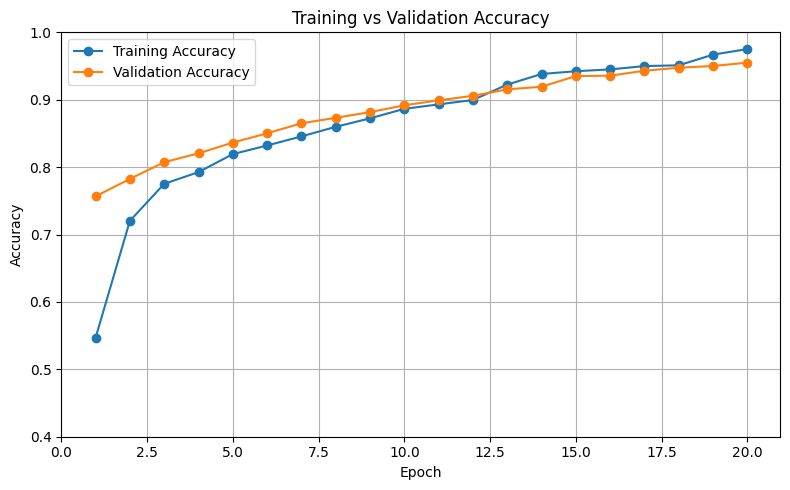

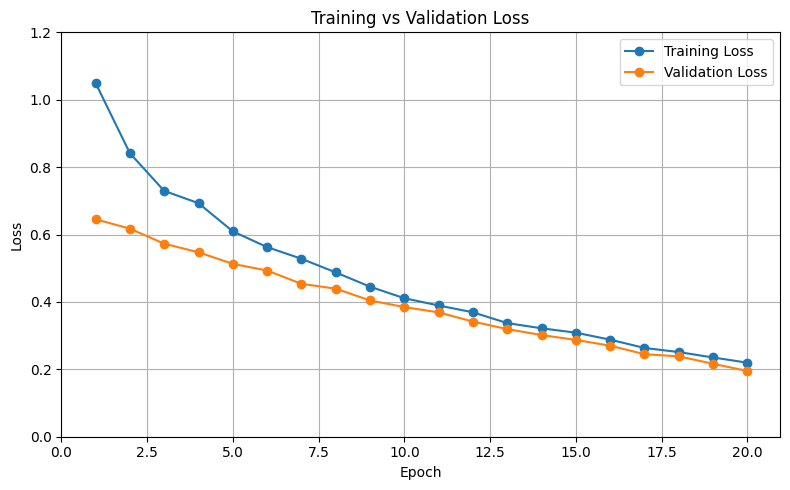

In [5]:

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


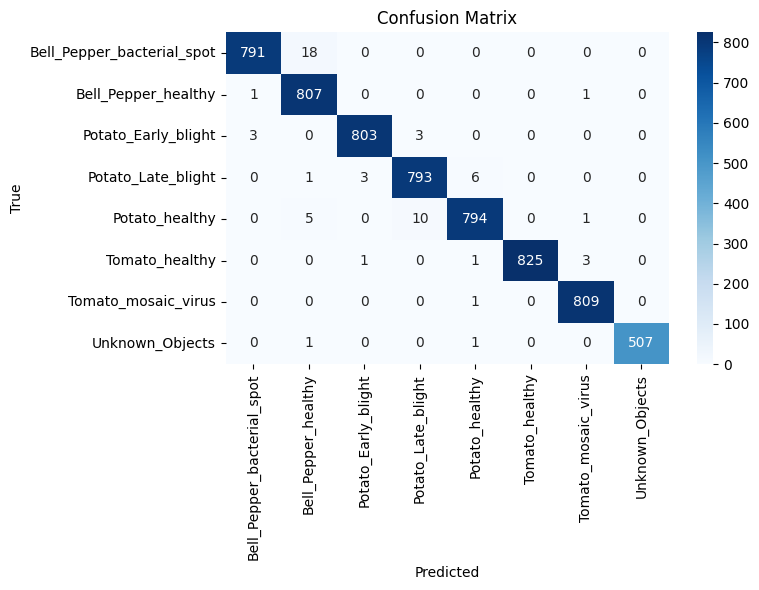


Classification Report:
                             precision    recall  f1-score   support

Bell_Pepper_bacterial_spot       0.95      0.97      0.96       797
       Bell_Pepper_healthy       0.96      0.94      0.96       825
       Potato_Early_blight       0.96      0.97      0.96       820
        Potato_Late_blight       0.96      0.96      0.96       805
            Potato_healthy       0.96      0.67      0.96       810
            Tomato_healthy       0.97      0.95      0.96       830
       Tomato_mosaic_virus       0.94      0.79      0.97       819
               Unknown_PNG       0.95      0.97      0.95       512

                  accuracy                           0.955      6218
                 macro avg       0.95      0.95      0.95      6218
              weighted avg       0.95      0.95      0.95      6218



In [6]:
test_gen.reset()
predictions = model.predict(test_gen, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels_sorted = list(test_gen.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels_sorted, yticklabels=class_labels_sorted)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

report = classification_report(true_classes, predicted_classes, target_names=class_labels_sorted)
print("Classification Report:\n", report)
